In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline    

In [2]:
file_name = "testSet.txt"
file = pd.read_table(file_name,header=None, names=["factor1","factor2","class"])
file.head()

,factor1,factor2,class
0,3.542485,1.977398,-1
1,3.018896,2.556416,-1
2,7.551510,-1.580030,1
3,2.114999,-0.004466,-1
4,8.127113,1.274372,1


Text(0, 0.5, 'factor2')

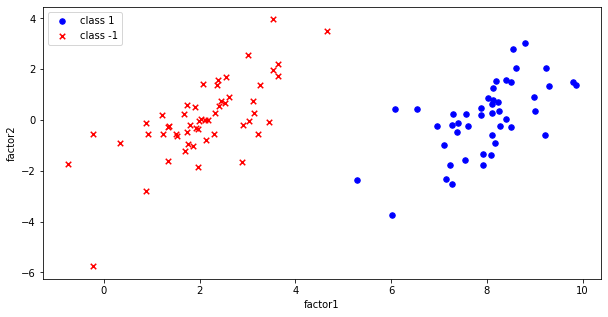

In [3]:
positive = file[file["class"] == 1]
negative = file[file["class"] == -1]
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(positive["factor1"], positive["factor2"], s=30, c="b", marker="o", label="class 1")
ax.scatter(negative["factor1"], negative["factor2"], s=30, c="r", marker="x", label="class -1")
ax.legend(loc="upper left")
ax.set_xlabel("factor1")
ax.set_ylabel("factor2")

In [4]:
def load_data_set(file):
    orig_data = file.values   
    cols = orig_data.shape[1]
    data_mat = orig_data[:,0:cols-1]
    label_mat = orig_data[:,cols-1:cols]
    return data_mat, label_mat
data_mat, label_mat = load_data_set(file)

In [5]:
#  给定输入i和m，随机输出一个0到m之间的与i不同的整数
def select_jrand(i, m):
    j = i
    while(j==i):
        j = int(random.uniform(0,m))
    return j

In [6]:
def clip_lambda(lambda_j, H, L):
    if lambda_j > H:
        lambda_j = H
    if L > lambda_j:
        lambda_j = L
    return lambda_j

$w^*=\sum_{i=1}^{N}\lambda_iy_ix_i$

In [7]:
def smo_simple(data_mat, class_label, C, toler, max_iter):
    # 循环外的初始化工作
    data_mat = np.mat(data_mat)
    label_mat = np.mat(class_label) 
    b = 0
    m,n = np.shape(data_mat)  
    lambdas = np.zeros((m,1))    
    iter = 0    
    while iter < max_iter:
        # 内循环的初始化工作
        lambda_pairs_changed = 0
        for i in range(m):   
            # 第一小段代码  
            WT_i = np.dot(np.multiply(lambdas, label_mat).T, data_mat)  
            g_xi = float(np.dot(WT_i, data_mat[i,:].T)) + b   
            Ei = g_xi - float(label_mat[i])    # 误差
            if((label_mat[i]*Ei < -toler) and  (lambdas[i] < C)) or \
            ((label_mat[i]*Ei > toler) and (lambdas[i] > 0)):  
                j = select_jrand(i, m) 
                WT_j = np.dot(np.multiply(lambdas, label_mat).T, data_mat)
                f_xj = float(np.dot(WT_j, data_mat[j,:].T)) + b    
                Ej = f_xj - float(label_mat[j])    
                lambda_iold = lambdas[i].copy()
                lambda_jold = lambdas[j].copy()

               # 第二小段代码
                if (label_mat[i] != label_mat[j]):  
                    L = max(0, lambdas[j] - lambdas[i])  # 
                    H = min(C, C + lambdas[j] - lambdas[i])
                else:                              
                    L = max(0, lambdas[j] + lambdas[i] - C)
                    H = min(C, lambdas[j] + lambdas[i])
                if H == L :continue

                # 第三小段代码
                eta = 2.0 * data_mat[i,:]*data_mat[j,:].T - data_mat[i,:]*data_mat[i,:].T - \
                data_mat[j,:]*data_mat[j,:].T
                if eta >= 0: 
                    continue
                lambdas[j] = (lambdas[j] - label_mat[j]*(Ei - Ej))/eta
                lambdas[j] = clip_lambda(lambdas[j], H, L)   
                if (abs(lambdas[j] - lambda_jold) < 0.00001):
                    continue


                lambdas[i] = lambdas[i] + label_mat[j]*label_mat[i]*(lambda_jold - lambdas[j])

                # 第四小段代码
                b1 = b - Ei + label_mat[i]*(lambda_iold - lambdas[i])*np.dot(data_mat[i,:], data_mat[i,:].T) +\
                label_mat[j]*(lambda_jold - lambdas[j])*np.dot(data_mat[i,:], data_mat[j,:].T)
                b2 = b - Ej + label_mat[i]*(lambda_iold - lambdas[i])*np.dot(data_mat[i,:], data_mat[j,:].T) +\
                label_mat[j]*(lambda_jold - lambdas[j])*np.dot(data_mat[j,:], data_mat[j,:].T)
                if (0 < lambdas[i]) and (C > lambdas[i]):
                    b = b1
                elif (0 < lambdas[j]) and (C > lambdas[j]):
                    b = b2
                else:
                    b = (b1 + b2)/2.0
                lambda_pairs_changed += 1
        if (lambda_pairs_changed == 0): iter += 1
        else: iter = 0
    return b, lambdas

In [8]:
b,lambdas = smo_simple(data_mat, label_mat, 0.6, 0.001, 10)
print(b, lambdas[lambdas>0])

[[-2.85590198]] [8.76733944e-02 6.87788495e-03 1.48717743e-01 8.67361738e-19
 7.04903052e-02 8.40376340e-02 8.87410834e-02]


Text(0, 0.5, 'factor2')

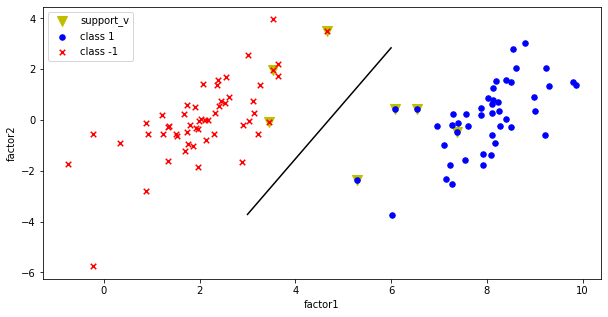

In [9]:
support_x = []
support_y = []
class1_x = []
class1_y = []
class01_x = []
class01_y = []
for i in range(100):
    if lambdas[i] > 0.0:
        support_x.append(data_mat[i,0])
        support_y.append(data_mat[i,1])        
for i in range(100):
    if label_mat[i] == 1:
        class1_x.append(data_mat[i,0])
        class1_y.append(data_mat[i,1])
    else:
        class01_x.append(data_mat[i,0])
        class01_y.append(data_mat[i,1])       
w_best = np.dot(np.multiply(lambdas, label_mat).T, data_mat)
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(support_x, support_y, s=100, c="y", marker="v", label="support_v")
ax.scatter(class1_x, class1_y, s=30, c="b", marker="o", label="class 1")
ax.scatter(class01_x, class01_y, s=30, c="r", marker="x", label="class -1")
lin_x = np.linspace(3,6)
lin_y = (-float(b) - w_best[0,0]*lin_x) / w_best[0,1]
plt.plot(lin_x, lin_y, color="black")  
ax.legend()
ax.set_xlabel("factor1")
ax.set_ylabel("factor2")